# <h1 align=center>Emotion Recognition</h1>

In [ ]:
# importando dependencias de trabajo
# importando librerias basicas
import os
import sys
import re
import gc

# importando modulos de analisis de datos, ML y graficas
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import Counter

# importando dependencias para tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# importando para sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# importando para modelos de keras
from keras.models import Model
# from keras.models import Sequential
# importando para keras capas
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Rescaling, InputLayer, MaxPool2D, BatchNormalization, Dropout, RandomFlip, RandomRotation, RandomContrast, RandomZoom, Resizing
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix
import cv2
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import kagglehub
import pathlib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

In [ ]:
# Download latest version of the dataset 
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Valentina\.cache\kagglehub\datasets\muhammadhananasghar\human-emotions-datasethes\versions\4


## Funciones Utiles

In [3]:
# funcion que recibe una lista numpy y recupera la forma de cada elemento, devuelve una lista con formas
def get_shape(data):
    # respuesta de la funcion
    ans = list()

    for d in data:
        sp = d.shape
        ans.append(sp)
    return ans

In [4]:
# funcion que transforma el entero de la clase a la palabra de la etiqueta, devuelve una lista de etiquetas
def class2label(data, labels):
    # respuesta de la funcion
    ans = list()

    for d in data:
        d = int(d)
        l = str(labels[d])
        ans.append(l)
    return ans

In [5]:
# funcion que estandariza los datos en numpy de acuerdo a un valor min & max, devuelve un arreglo np flotante
def std_data(data, minv, maxv):
    rangev = maxv - minv
    ans = data.astype("float32")/float(rangev)
    # ans = pd.Series(ans)
    # respuesta de la funcion
    return ans

## Cargar y Preparar los Datos

Los pasos de esta seccion son:

1. Leer los datos de la carpeta
2. Formatear los datos para que los acepte el DataFrame de Pandas.
2. Crear el DataFrame de Pandas con un esquema propio.
2. Formatear los datos para pobrar el DataFrame de pandas.
3. Revisar que todo este como deberia estar.

In [11]:
train_directory='EmotionsDataset_Splitted/train'
val_directory="EmotionsDataset_Splitted/test"

In [12]:
# lista de nombres de las clasificaciones de emociones
label_names = [     # label number
    "angry",        # 0
    "happy",        # 1
    "nothing",      # 2
    "sad",          # 3
]

In [30]:
# Image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 32

In [31]:
# nombres de columnas para el dataframe de pandas
col_names = [           # nombre de columna DF
    "img_data",         # datos de la imagen
    "img_shape",        # forma de la imagen
    "class",            # clase de la imagen, de 0 a 9
    "label",            # nombre de la clase
    "std_img_data",     # datos de la imagen estandarizados
    "cat_labels"        # etiquetas categoricas de la clase
]
# "ReshapeData", "Label", "Class", "DataSize", "ReshapeSize", "ResKeras", "ScoreKeras"]
# creando dataframe con columnas vacio
emotions_df = pd.DataFrame(columns=col_names)

In [53]:
# Cargar conjuntos de datos desde los directorios
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',  # Etiquetas enteras (0, 1, 2, 3 según el orden en label_names)
    class_names=label_names,  # Nombres de las clases
    image_size=(img_height, img_width),  
    batch_size=batch_size,
    shuffle=True
)

Found 3152 files belonging to 4 classes.


In [54]:
# Convertir las imágenes a blanco y negro (escala de grises)
train_dataset = train_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

In [55]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='int',  # Etiquetas enteras
    class_names=label_names,
    image_size=(img_height, img_width),  
    batch_size=batch_size,
    shuffle=True
)

Found 788 files belonging to 4 classes.


In [56]:
# Convertir las imágenes a blanco y negro (escala de grises)
val_dataset = val_dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))

In [57]:
# Convertir dataset a NumPy para trabajar con SMOTE
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

In [58]:
x_train, y_train = dataset_to_numpy(train_dataset)
x_val, y_val = dataset_to_numpy(val_dataset)

In [59]:
# Mostrar distribución de clases antes del balanceo
print("Distribución inicial de clases (entrenamiento):", np.bincount(y_train))
print("Distribución inicial de clases (validación):", np.bincount(y_val))

Distribución inicial de clases (entrenamiento): [850 830 874 598]
Distribución inicial de clases (validación): [213 207 219 149]


In [61]:
# Aplanar imágenes para aplicar SMOTE
x_train_flat = x_train.reshape(x_train.shape[0], -1)

In [62]:
# Aplicar SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flat, y_train)

In [63]:
# Convertimos de nuevo X_resampled a la forma de imágenes 28x28 para el modelo de CNN
x_train_resampled = x_train_resampled.reshape(-1, 128, 128, 1)

In [64]:
# Verificar distribución de clases después del balanceo
print("Distribución balanceada de clases (entrenamiento):", np.bincount(y_train_resampled))

Distribución balanceada de clases (entrenamiento): [874 874 874 874]


In [65]:
# Convertir etiquetas a categóricas (one-hot encoding) si se necesita para la red
y_train_categorical = tf.keras.utils.to_categorical(y_train_resampled, num_classes=len(label_names))
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=len(label_names))

In [66]:
# Verificar formas de los datos
print("Forma de x_train_resampled:", x_train_resampled.shape)
print("Forma de y_train_categorical:", y_train_categorical.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de y_val_categorical:", y_val_categorical.shape)

Forma de x_train_resampled: (3496, 128, 128, 1)
Forma de y_train_categorical: (3496, 4)
Forma de x_val: (788, 128, 128, 1)
Forma de y_val_categorical: (788, 4)


In [67]:
# Recuperar forma de las imágenes
img_shape = x_train_resampled.shape[1:]

# Recuperar etiquetas de las clases
labels = [label_names[label] for label in y_train_resampled]

# Establecer datos estandarizados
scaler = StandardScaler()
x_train_resampled_flat = x_train_resampled.reshape(x_train_resampled.shape[0], -1)
std_img_data = scaler.fit_transform(x_train_resampled_flat)

# Categorizando las clases a aprender
cat_labels = to_categorical(y_train_resampled, len(label_names))

In [ ]:
# Convertir datos a listas para agregarlos al DataFrame
img_data = x_train_resampled.tolist()
std_img_data = std_img_data.tolist()
cat_labels = cat_labels.tolist()

In [48]:
class_data =y_train_resampled
img_shape = [img_shape] * len(img_data)

# definir arreglo basico de datos
data_lt = (
    img_data,       # datos de la imagen   0
    img_shape,      # forma de la imagen   1
    class_data,     # clase de la imagen   2
    labels,         # nombre de la clase   3
    std_img_data,   # datos de la imagen estandarizados 4
    cat_labels,     # etiquetas categoricas de la clase 5
)

In [49]:
# poblamdo las columnas del dataframe
for col, data in zip(col_names, data_lt):
    emotions_df[col] = data

In [50]:
emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img_data      3496 non-null   object
 1   img_shape     3496 non-null   object
 2   class         3496 non-null   int32 
 3   label         3496 non-null   object
 4   std_img_data  3496 non-null   object
 5   cat_labels    3496 non-null   object
dtypes: int32(1), object(5)
memory usage: 150.3+ KB


In [51]:
# imprime el encabezado del dataframe
emotions_df.head()

,img_data,img_shape,class,label,std_img_data,cat_labels
0,"[[[104.984375, 59.484375, 17.71875], [100.8437...","(128, 128, 3)",3,sad,"[-0.29601356387138367, -0.8008967041969299, -1...","[0.0, 0.0, 0.0, 1.0]"
1,"[[[167.8125, 153.8125, 144.8125], [184.703125,...","(128, 128, 3)",1,happy,"[0.47078680992126465, 0.3818857967853546, 0.39...","[0.0, 1.0, 0.0, 0.0]"
2,"[[[4.546875, 24.6875, 18.296875], [17.390625, ...","(128, 128, 3)",2,nothing,"[-1.5218262672424316, -1.237215518951416, -1.1...","[0.0, 0.0, 1.0, 0.0]"
3,"[[[223.5625, 209.3125, 203.65625], [206.4375, ...","(128, 128, 3)",1,happy,"[1.1512006521224976, 1.0778015851974487, 1.129...","[0.0, 1.0, 0.0, 0.0]"
4,"[[[230.296875, 179.296875, 158.296875], [220.7...","(128, 128, 3)",0,angry,"[1.2333918809890747, 0.7014349102973938, 0.566...","[1.0, 0.0, 0.0, 0.0]"


In [52]:
# libero memoria
gc.collect()

1132

## Revisando los Datos
Es importante revisar los datos para saber que se esta trabajando con ellos. En esta sección se revisa la forma de los datos, se visualizan algunas imágenes y se revisa la distribución de las clases.

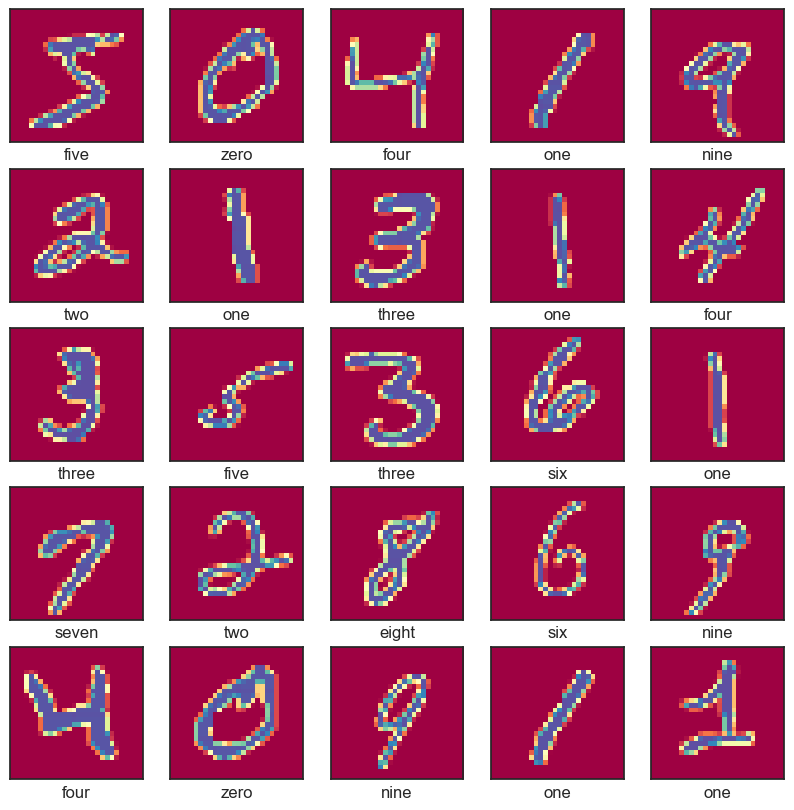

In [ ]:
# pruebo imagenes del dataset
# imagen de 5x5 subplots con tamaño de 10x10
sns.set_theme(style="white")
plt.figure(figsize=(10, 10))
# recorriendo las imagenes
for i in range(25):
    # creando subplots
    plt.subplot(5, 5, i+1)
    # xticks y yticks desactivados
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # tomo la imagen de la columna de datos de la imagen
    # el mapa de colores es viridis de matplotlib
    # otras opciones son: "plasma", "viridis", "BuPu", "hsv", "Spectral"
    plt.imshow(emotions_df["img_data"][i],
               cmap=plt.cm.Spectral)
    # tomo el nombre de la clase de la columna de etiquetas
    plt.xlabel(emotions_df["label"][i])

## Preprocesar los Datos

Los pasos de esta seccion son:

1. Revisar que los datos esten bien.
2. Elegir la caracteristicas o propiedades de aprendizaje.
3. Elegir la variable objetivo del aprendizaje.
4. Dividir la conjunto de datos entre las poblaciones de entrenamiento y pruebas.
5. Formatear los datos de aprendizaje y objetivo acorde a la red neuronal.

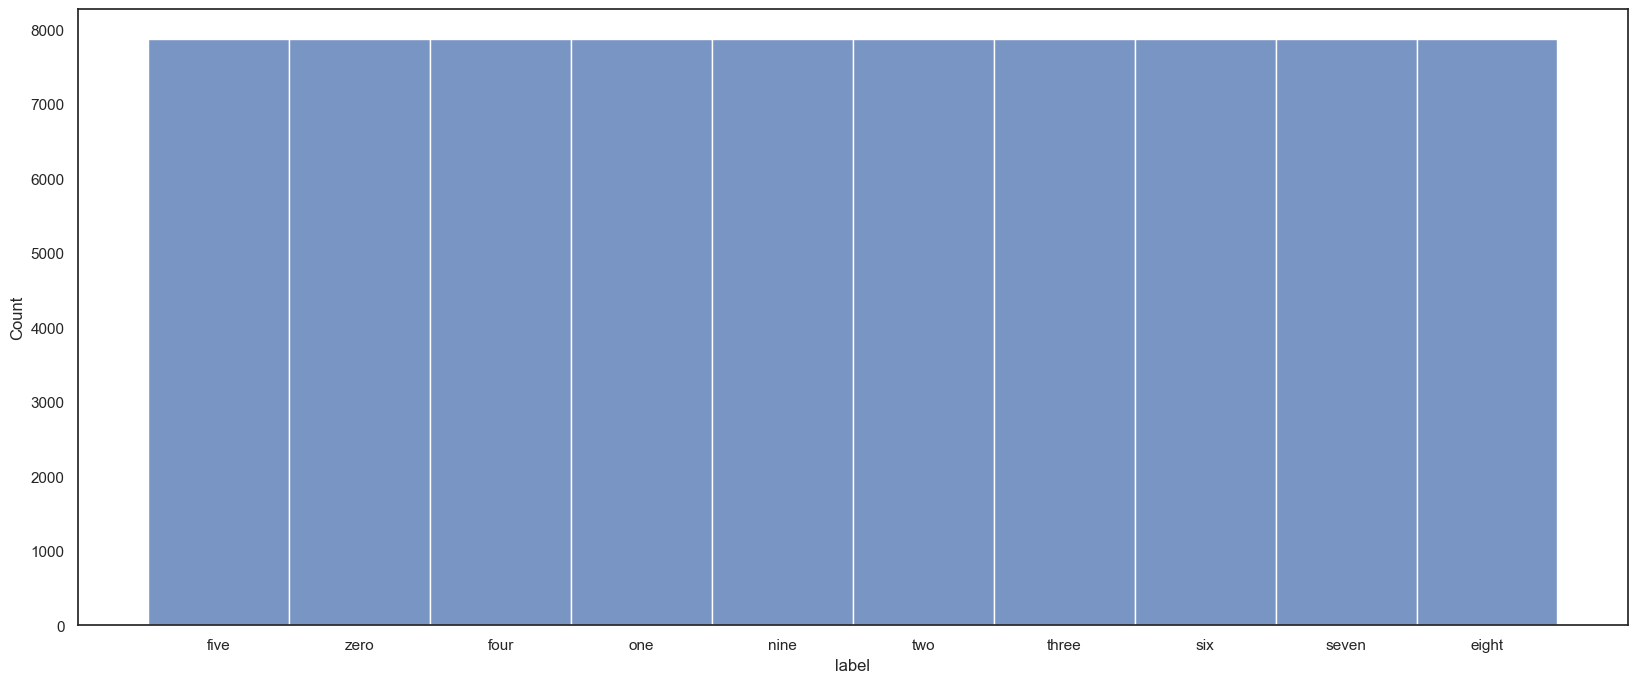

In [ ]:
# cchequeo la distribucion de datos
plt.figure(figsize=(20, 8))
sns.set_theme(style="white")
sns.histplot(emotions_df[col_names[3]])
plt.show()

In [ ]:
# seleccionando caracteristicas de aprendizaje y variables objetivo
# recuperando la forma de las imagenes basado en el primer elemento de la lista

# recuperando los valores y ajustando el tensor para la CNN
A = digit_df[col_names[4]]
# recuperando los valores de la cateogoria
b = digit_df[col_names[5]].values

# fortateo de datos numpy
X = np.array([np.array(i, dtype="object") for i in A], dtype="object")
y = np.array([np.array(j, dtype="object") for j in b], dtype="object")

print(X.shape)
# forma basica general de las imagenes
imgsh = X[0].shape
# ajuste de forma para el modelo CNN
X = X.reshape(digit_df.shape[0], imgsh[0], imgsh[1], 1)
print(X.shape)

(78770, 28, 28)
(78770, 28, 28, 1)


In [ ]:
# semilla para el random
rseed = 42

# en tamanho de la muestra para pruebas esta entre 0.2 y 0.3
train_pop = 0.8
test_pop = 1.0 - train_pop

In [ ]:
# distribuir los datos entre entrenamiento vs. pruebas
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = test_pop, random_state = rseed)

In [ ]:
# formateo para keras y tensorflow
X_train = tf.convert_to_tensor(X_train, dtype="float64")
y_train = tf.convert_to_tensor(y_train, dtype="float64")
X_test = tf.convert_to_tensor(X_test, dtype="float64")
y_test = tf.convert_to_tensor(y_test, dtype="float64")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(63016, 28, 28, 1) (63016, 10) (15754, 28, 28, 1) (15754, 10)


##### DATA VISUALIZATION

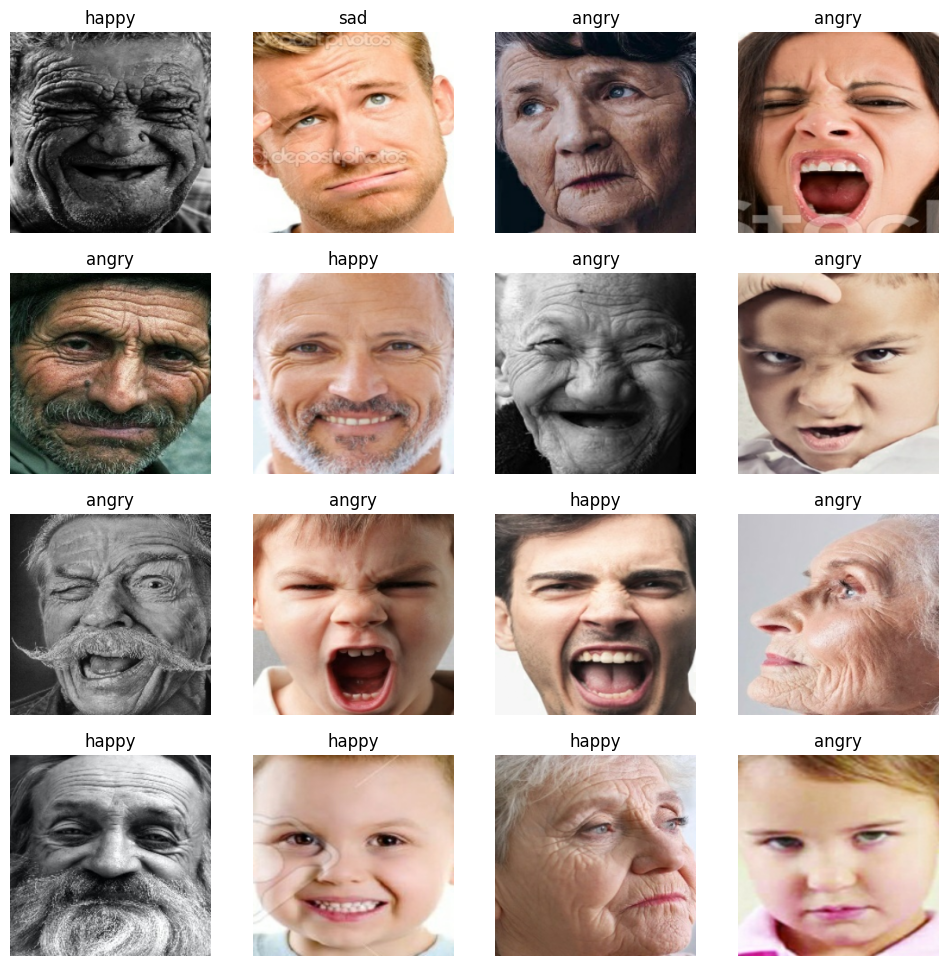

In [11]:
plt.figure(figsize=(12,12))
for images,labels in train_dataset.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CLASS_NAMES[tf.argmax(labels[i],axis=0)])
        plt.axis('off')

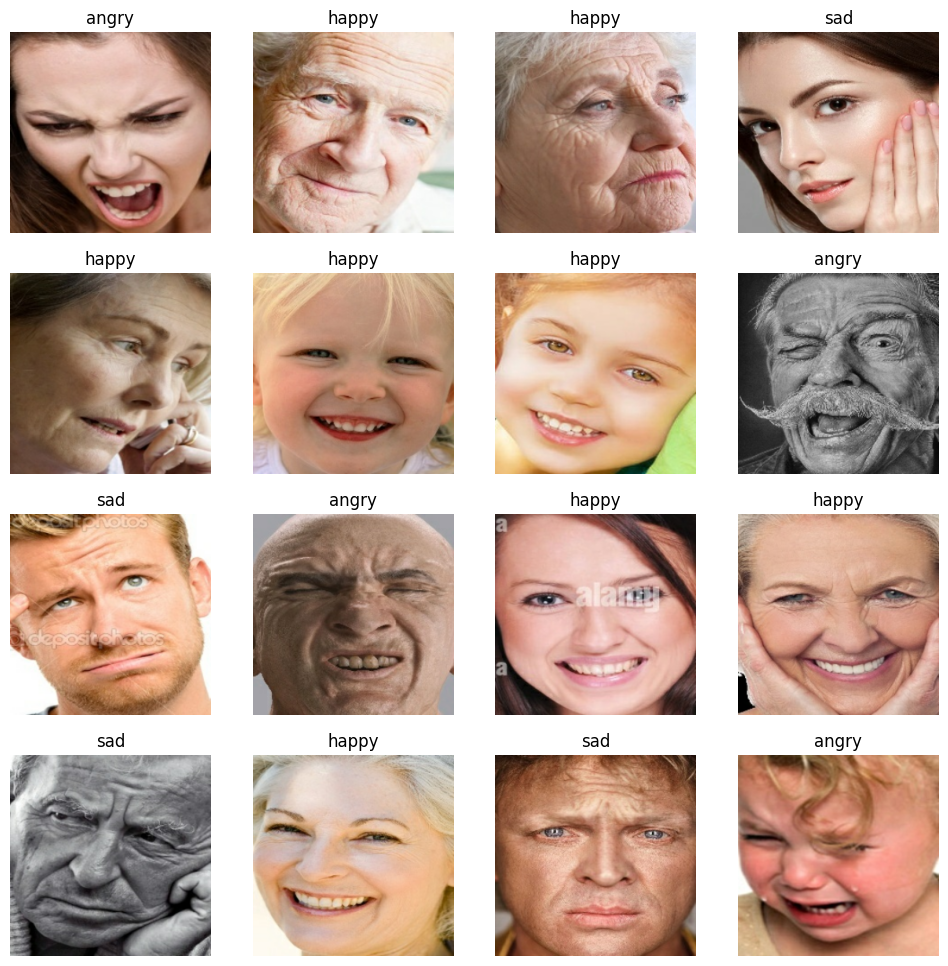

In [12]:
plt. figure(figsize = (12,12))
for images, labels in train_dataset. take (1) :
    for i in range (16):
        ax = plt.subplot(4,4, i+1)
        plt. imshow(images [i]/255)
        plt. title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy ()])
        plt.axis ("off")

##### DATA PREPARATION

In [13]:
training_dataset = (
        train_dataset
        .prefetch(tf.data.AUTOTUNE)
)

In [14]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [15]:
validation_dataset = (
        val_dataset
        .prefetch(tf.data.AUTOTUNE)
)

In [16]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [17]:
resize_rescale_layers=tf.keras.Sequential([Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
            Rescaling(1./255)
])

In [18]:
# Definir capas de data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomContrast(0.2),
    RandomZoom(0.2),
])

#### MODELING

In [19]:
# Definir el modelo
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3)),
    data_augmentation,  # Aplicar data augmentation en el modelo
    Rescaling(1./255, name="rescaling"),

    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"], padding='valid', activation='relu',
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters=CONFIGURATION["N_FILTERS"] * 2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],
           strides=CONFIGURATION["N_STRIDES"], padding='valid', activation='relu',
           kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"], strides=CONFIGURATION["N_STRIDES"] * 2),

    Flatten(),
    
    Dense(CONFIGURATION["N_DENSE_1"], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),
    
    Dense(CONFIGURATION['N_DENSE_2'], activation="relu", kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax"),
])

lenet_model.summary()

C:\Users\Valentina\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 68)   │        19,652 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 68)   │           272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 68)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 261392)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │   535,332,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536,414,679 (2.00 GB)

 Trainable params: 536,409,359 (2.00 GB)

 Non-trainable params: 5,320 (20.78 KB)

#### TRAINING

In [20]:
# Definir función de pérdida y métricas
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_k_accuracy')
]

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [ ]:
# Compilar el modelo
lenet_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss=loss_function,
    metrics=metrics
)

# Prefetching de los datos para un mejor rendimiento
training_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Entrenar el modelo
history = lenet_model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=CONFIGURATION['N_EPOCHS'],
    verbose=1,
    callbacks=[early_stopping]
)

# Guardar el modelo en formato .keras
lenet_model.save("best_emotions_model.keras")


Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2808s 39s/step - accuracy: 0.4182 - loss: 6.8912 - top_k_accuracy: 0.7448 - val_accuracy: 0.3673 - val_loss: 6.9183 - val_top_k_accuracy: 0.6239
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 1464s 19s/step - accuracy: 0.4569 - loss: 6.1424 - top_k_accuracy: 0.7808 - val_accuracy: 0.3638 - val_loss: 8.6512 - val_top_k_accuracy: 0.6678
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 1925s 27s/step - accuracy: 0.4841 - loss: 5.8924 - top_k_accuracy: 0.7946 - val_accuracy: 0.4060 - val_loss: 8.1848 - val_top_k_accuracy: 0.6257
Epoch 4/15
53/72 ━━━━━━━━━━━━━━━━━━━━ 13:59 44s/step - accuracy: 0.4745 - loss: 5.6904 - top_k_accuracy: 0.7897

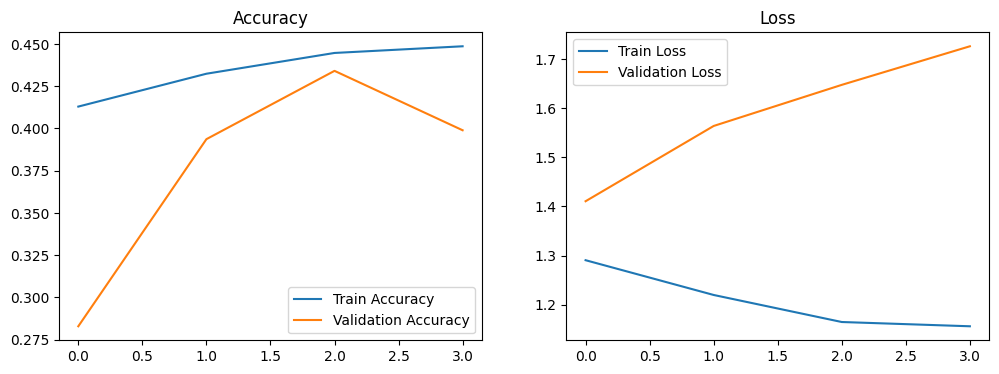

In [ ]:
# Visualización de las métricas de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()